## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime as dtz
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

## Funciones

In [2]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x 

## Importar datos

In [4]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")
bks_drp = np.load("data/bks_drp.npy")

In [4]:
adcp

<xarray.Dataset>
Dimensions:       (beam: 4, bin: 25, time: 3127640)
Coordinates:
  * time          (time) datetime64[ns] 2012-02-16T14:45:00 ... 2012-03-14T18...
Dimensions without coordinates: beam, bin
Data variables: (12/30)
    east_vel      (time, bin) float64 ...
    north_vel     (time, bin) float64 ...
    vert_vel      (time, bin) float64 ...
    error_vel     (time, bin) float64 ...
    corr          (time, bin, beam) float64 ...
    status        (time, bin, beam) float64 ...
    ...            ...
    bt_corr       (time, beam) float64 ...
    bt_ampl       (time, beam) float64 ...
    bt_perc_good  (time, beam) float64 ...
    config        int32 ...
    name          object ...
    range         (bin) float64 ...
Attributes:
    src:      C://Users//vicho//Desktop//F16M5000.000

In [5]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])

# Obtener backscatter

In [6]:
# %script to calculate the acoustic backscatter from an
# %RDI
# % From Laurent from Alex
# %
# % this followes Deines 1999 method.  Needs to be altered re: JTECH 2010
# % paper by G....iaux and van Haren. 
# ​
# %R=cfg.ranges/(cos(pi/180*cfg.beam_angle));
R = adcp.config.ranges/(np.cos(np.pi/180*adcp.config.beam_angle))
if (adcp.config.beam_freq==1200):
  print('Using constants for 1200kHz ADCP.')
  taR=2*.48*R;    # for 1200
elif (adcp.config.beam_freq==600): 
  print('Using constants for 600kHz ADCP.')
  taR=2*.153*R;    # for 600

ldbm=10*np.log10(adcp.config.xmit_pulse)
#ldbm=10*log10(cfg.xmit_pulse);
kk=np.mean(adcp.intens,2)
bsk=0.458*(kk-40)
Sv = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
for i in range(adcp.config.n_cells):
    Sv[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk[:,i]


Using constants for 1200kHz ADCP.


In [7]:
adcp.intens.isel(beam=0)

<xarray.DataArray 'intens' (time: 3127640, bin: 25)>
array([[ 91.,  83.,  78., ...,  45.,  44.,  44.],
       [ 90.,  84.,  78., ...,  45.,  46.,  43.],
       [ 90.,  83.,  79., ...,  44.,  44.,  45.],
       ...,
       [206., 215., 213., ..., 206., 165., 131.],
       [208., 217., 215., ..., 196., 179., 151.],
       [206., 214., 210., ..., 151., 125., 115.]])
Coordinates:
  * time     (time) datetime64[ns] 2012-02-16T14:45:00 ... 2012-03-14T18:18:3...
Dimensions without coordinates: bin

In [8]:
y_bin = np.linspace(0.91, 3.31, 25)
n_time = len(adcp.temperature)

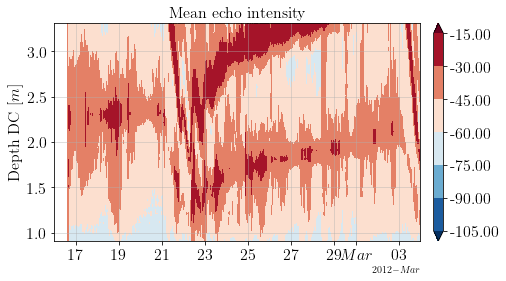

In [11]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Mean echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         Sv,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(dtz.date(2012,2,16),dtz.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

# Eliminar valores

In [10]:
z = DC_1["Depth"]
Sv_new = Sv.copy()
for i in range(n_time-19):
    cont = 0
    for j in y_bin:
        if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
            i = i+1
        if z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] <= j:
            cont+=1
        elif z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] > j:
            break
    Sv_new[cont:, i] = np.nan
        

In [11]:
# np.save("data/bks_drp.npy", Sv_new) 

In [17]:
for j in y_bin:
    print(j)


0.91
1.01
1.11
1.21
1.31
1.41
1.51
1.6099999999999999
1.71
1.81
1.91
2.01
2.11
2.21
2.31
2.4099999999999997
2.51
2.61
2.71
2.81
2.9099999999999997
3.01
3.11
3.21
3.31


In [13]:
adcp.time.shape

(3127640,)

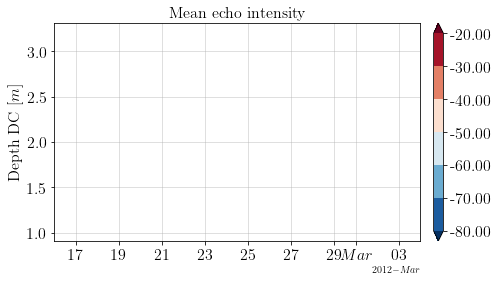

In [9]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Mean echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(dtz.date(2012,2,16),dtz.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

In [47]:
test = np.ones((7,5))
print(test)
test[3:,0] = np.nan
test[4:,3] = np.nan
test[5:,4] = np.nan
print(test)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [nan  1.  1.  1.  1.]
 [nan  1.  1. nan  1.]
 [nan  1.  1. nan nan]
 [nan  1.  1. nan nan]]


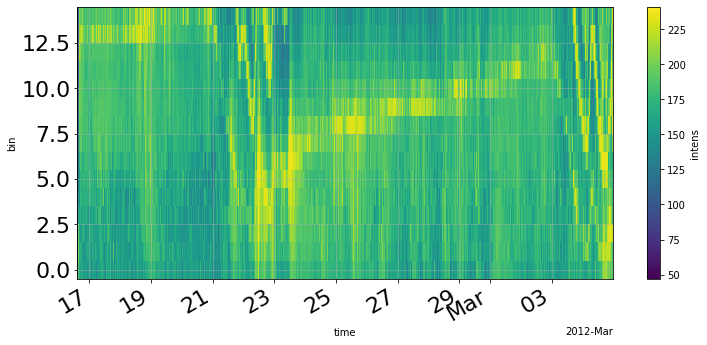

In [3]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 1].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

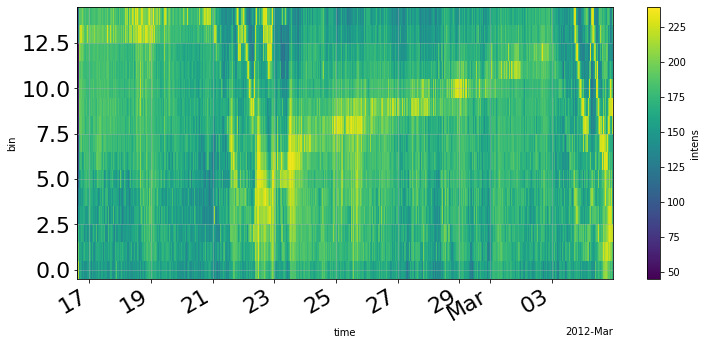

In [4]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 2].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

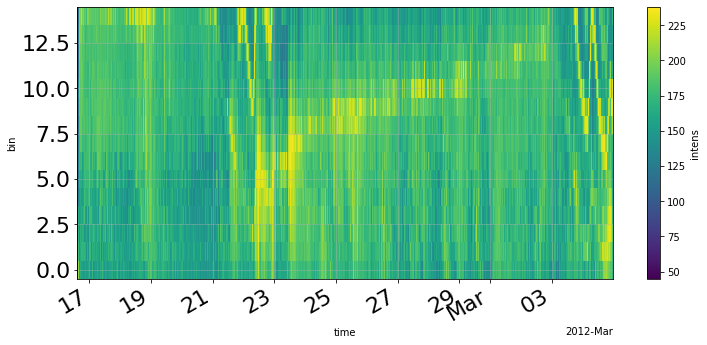

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 3].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

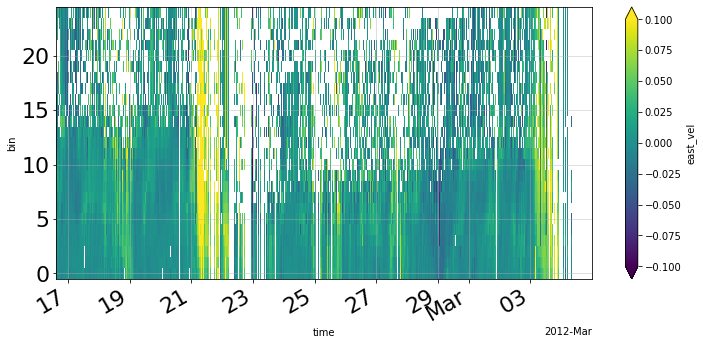

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

contourf_ = feb16.sel(time=slice(None,"2012-03-04")).east_vel.plot(x='time', y='bin', ax=ax, vmin=-0.1, vmax=0.1)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)


# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

In [3]:
feb16

<xarray.Dataset>
Dimensions:       (beam: 4, bin: 25, time: 3127640)
Coordinates:
  * time          (time) datetime64[ns] 2012-02-16T14:45:00 ... 2012-03-14T18...
Dimensions without coordinates: beam, bin
Data variables: (12/30)
    east_vel      (time, bin) float64 ...
    north_vel     (time, bin) float64 ...
    vert_vel      (time, bin) float64 ...
    error_vel     (time, bin) float64 ...
    corr          (time, bin, beam) float64 ...
    status        (time, bin, beam) float64 ...
    ...            ...
    bt_corr       (time, beam) float64 ...
    bt_ampl       (time, beam) float64 ...
    bt_perc_good  (time, beam) float64 ...
    config        int32 ...
    name          object ...
    range         (bin) float64 ...
Attributes:
    src:      C://Users//vicho//Desktop//F16M5000.000